 # Tutorial: PASCode-RRA
 PASCode ensembles multiple Differential Abundance (DA) tools through a Robust Rank Aggregation (RRA) algorithm to obtain an *aggregated phenotype label* for each cell.

 This label has 3 possible values: *positive aggregated phenotype label*, cells associated with the postive condition of the phenotype (e.g., disease); *negative aggregated phenotype label*, cells associated with the negative condition of the phenotype (e.g., control); *non-label*, cells associated with neither condition.

 Users have the options to choose which DA tools to use. Current available options are: Milo, MELD, DAseq, CNA.

 Here we provide two use cases:
 1) Running our integrative function to get aggregated labels with just one function call. This includes automatically running the selected DA methods, followed by RRA.
 2) Running DA methods and RRA separately, which allows users to customize the DA methods and parameters.

## Preparation

### Import

In [1]:
import PASCode
import scanpy as sc
import matplotlib.pyplot as plt

DATA_PATH = "./data/"

### Load data
 We need to load the anndata object, which is required to have preprocessed single-cell measurements data (e.g., gene expression) stored in anndata.X, and information of conditions and subject IDs stored in anndata.obs

In [2]:
adata = sc.read_h5ad(DATA_PATH + 'synth_demo_2v6_sparse.h5ad')
adata.X = adata.X.toarray()
print(adata)

AnnData object with n_obs × n_vars = 11674 × 2000
    obs: 'celltype', 'phenotype', 'subject_id'


#### Specify column names for subject ID, condition, and positive/negative conditions

In [3]:
cond_col = 'phenotype' # condition column
pos_cond = 'cond1' # positive condition
neg_cond = 'cond2'  # negative condition
subid_col = 'subject_id' # subject id column

#### (Optional) Subsample subjects
 Users can choose to subsample a subset of subjects with equal condition numbers. **This is recommended to achieve higher accuracy when the subject numbers of the two phenotype conditions are highly imbalanced**. Our benchmarking results showed significant decrease in performance of DA tools for imbalanced subject numbers across phenotypes (e.g., 10 disease vs. 30 control subjects). This can be alleviated by traininig a graph attention network on subsampled balanced data, and predict PAC scores on the entire dataset (see Tutorial_PASCode-ScorePrediction).

In [ ]:
adata0 = adata.copy()
adata = PASCode.utils.subsample_donors(
    adata=adata,
    subsample_num=None, # Can be set to cond1_number:cond2_number, e.g., "2:2". If None, the function will automatically subsample to the smaller number of subjects in the two conditions.
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    sex_col=None,)

Before donor subsampling:
phenotype
cond2    6
cond1    2
Name: count, dtype: int64
'subsample_num' not provided. Automatically subsample to the minimum number of subjects in the two conditions.
Donor subsampling:  2:2
After donor subsampling:
phenotype
cond2    2
cond1    2
Name: count, dtype: int64


## Use Case 1: Run the integrative function to get aggregated labels directly.

In [ ]:
adata.obs['aggreg_label'] = PASCode.da.agglabel(
    adata,
    subid_col,
    cond_col,
    pos_cond,
    neg_cond,
    da_methods=['milo','meld','daseq'] # recommended combination to achieve higher accuracy
)

============================= DA and RRA... =============================
'use_pre' not found in adata.obsm.
Scaling...
Running PCA...
Computing connectivities...



----------------------------- Milo started ... -----------------------------
Making neighborhoods...
Counting neighborhoods...
Running differential abundance testing...
----------------------------- Milo Time cost (s):  5.22  -----------------------------


 ----------------------------- MELD started ... -----------------------------
Building graph on 5942 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.54 seconds.
  Calculating affinities...
  Calculated affinities in 0.16 seconds.
Calculated graph and diffusion operator in 2.15 seconds.
----------------------------- MELD Time cost (s):  2.33  -----------------------------


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    
----------------------------- DAseq started ... -----------------------------
Calculating DA 

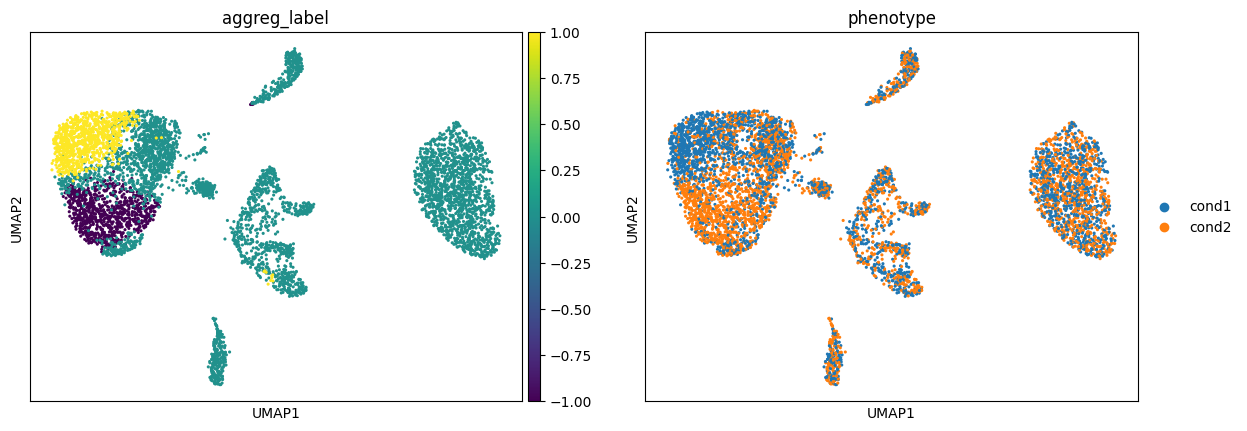

In [6]:
# Visualize the aggregated labels.
sc.tl.umap(adata)
sc.pl.umap(adata, color=['aggreg_label', 'phenotype'])

## Use Case 2: Run DA methods and RRA separately with customizations.

### Run DA methods
 1) Users can customize parameters in each DA method. For illustrations of those parameters, we refer users to the relevant DA methods' documentations.
 2) Some DA methods by default use `adata.obsp['connectivities']` for computation. If not provided, `scanpy.pp.neighbors()` will be run. Users can calculate the connectivity matrix using their own choice of algorithm in advance, and make sure relevant fileds such as `adata.uns` and `adata.obsp` are updated accordingly.
 3) Some DA methods by default use adata.obsm['X_pca'] for graph construction. If not provided, `scanpy.pp.pca()` will be run. Users can specify which representation to use (in `adata.obsm`).

#### Run Milo


----------------------------- Milo started ... -----------------------------
Making neighborhoods...
Counting neighborhoods...
Running differential abundance testing...
----------------------------- Milo Time cost (s):  2.58  -----------------------------



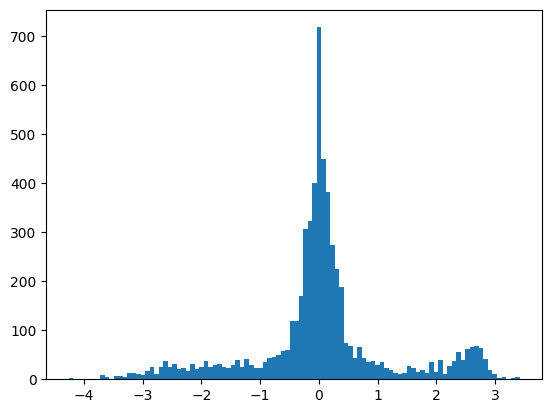

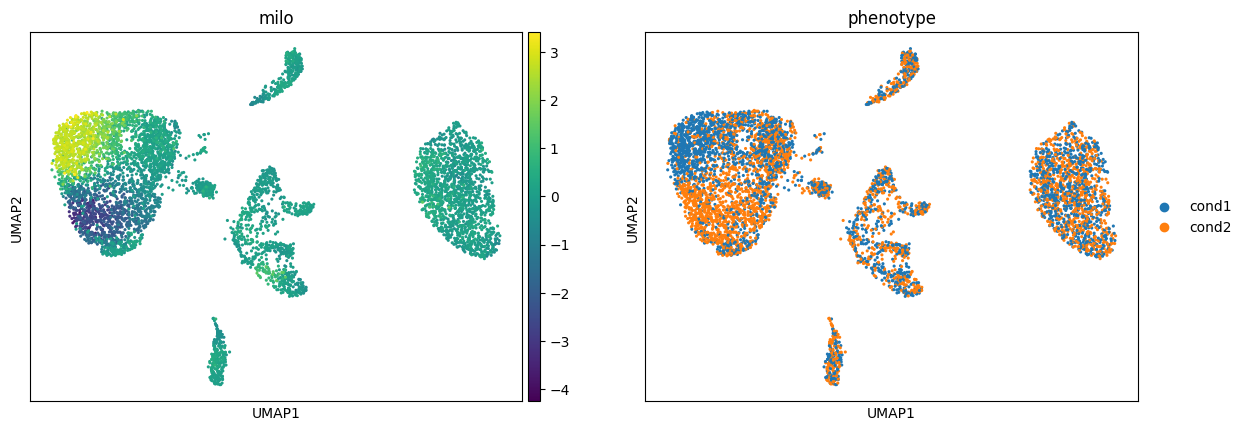

In [ ]:
PASCode.da.run_milo(
    adata,
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    make_nhoods_prop=0.1, # choose 0.05 for larger dataset (n_cells > 1e5, according to Milo's supp. notes)
    use_rep='X_pca')

plt.hist(adata.obs['milo'], bins=100)
sc.pl.umap(adata, color=['milo', 'phenotype'])

#### Run MELD


 ----------------------------- MELD started ... -----------------------------
Building graph on 5942 samples and 50 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculated KNN search in 1.50 seconds.
  Calculating affinities...
  Calculated affinities in 0.16 seconds.
Calculated graph and diffusion operator in 1.93 seconds.
----------------------------- MELD Time cost (s):  2.12  -----------------------------



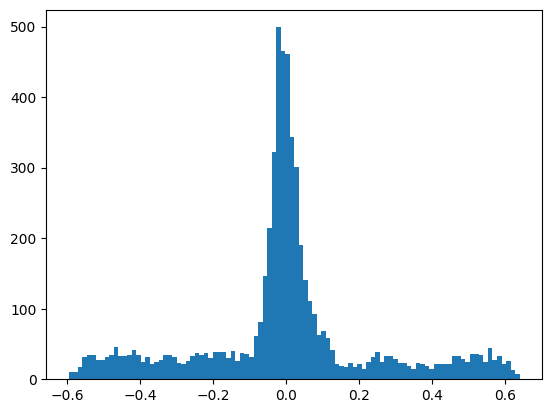

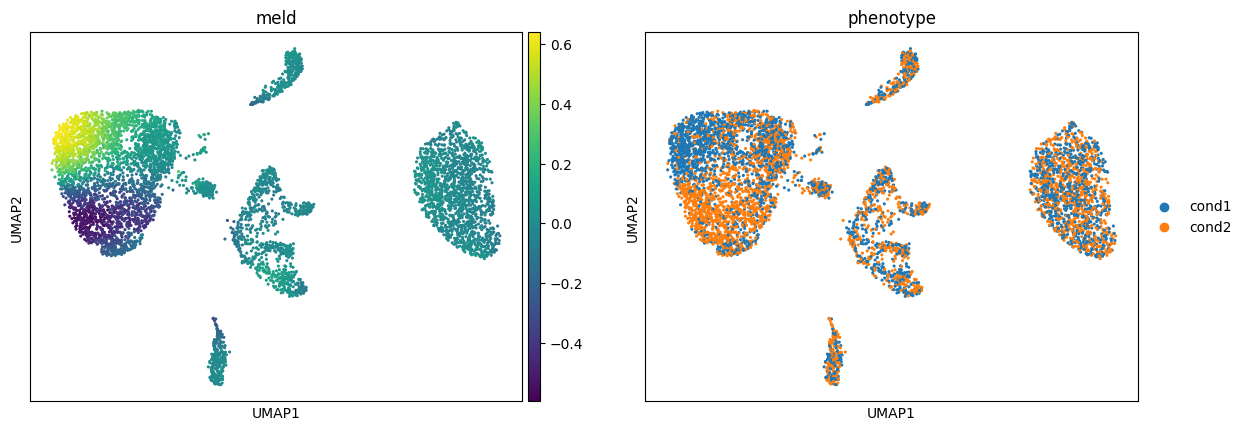

In [ ]:
PASCode.da.run_meld(
    adata,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    beta=10, knn=15, # recommended to achieve higher accuracy
    use_rep='X_pca')

plt.hist(adata.obs['meld'], bins=100)
sc.pl.umap(adata, color=['meld', 'phenotype'])

#### Run DAseq


----------------------------- DAseq started ... -----------------------------
Calculating DA score vector.
Running GLM.
Test on random labels.
Setting thresholds based on permutation
----------------------------- DA-seq Time cost (s):  91.67  -----------------------------



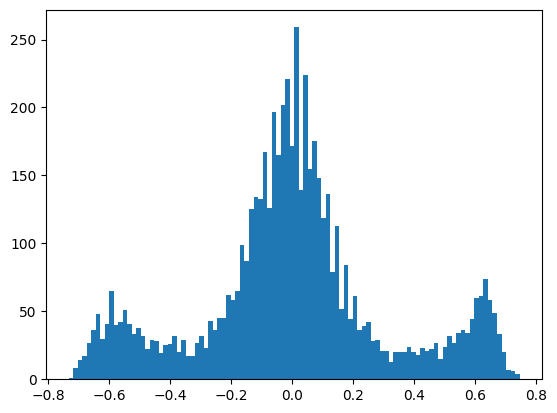

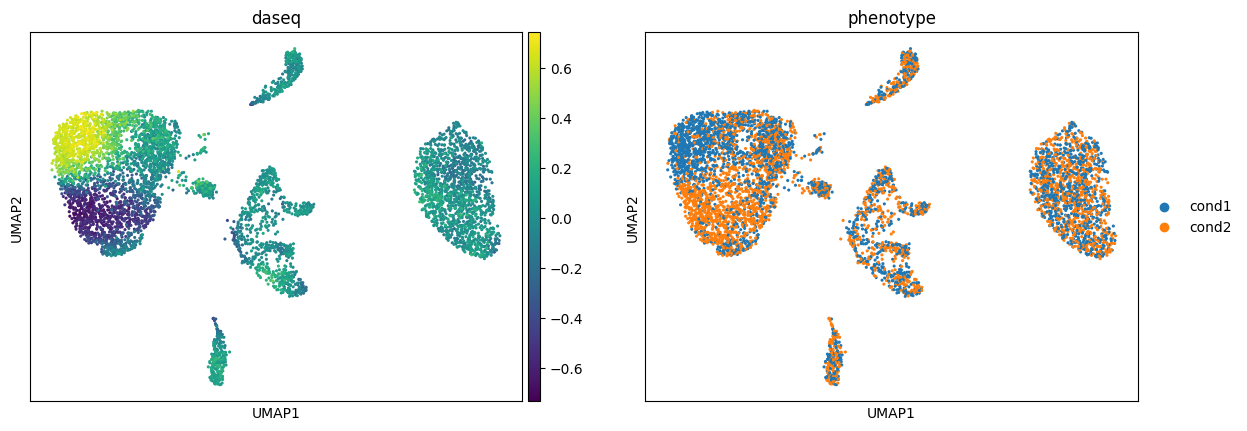

In [ ]:
PASCode.da.run_daseq(
    adata,
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    k=[50,500,50], # default
    use_rep='X_pca')

plt.hist(adata.obs['daseq'], bins=100)
sc.pl.umap(adata, color=['daseq', 'phenotype'])

#### Run CNA
 CNA may incur low sample size error with small dataset, thus we use a larger dataset here for demonstration purposes.

'use_pre' not found in adata.obsm.
Scaling...
Running PCA...
Computing connectivities...

----------------------------- CNA started ... -----------------------------
['celltype' 'phenotype' 'subject_id']
consider casting to numeric types where appropriate, and
consider re-coding text-valued columns with pandas.get_dummies
----------------------------- CNA Time cost (s):  8.09  -----------------------------



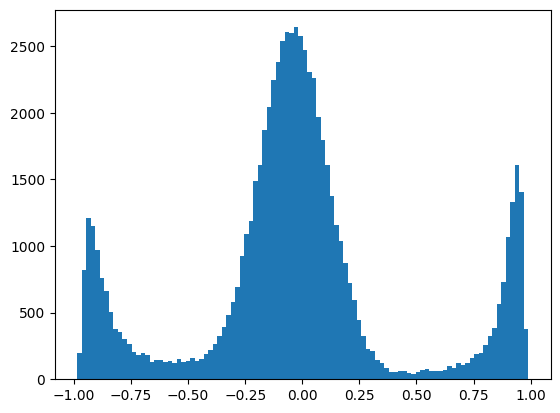

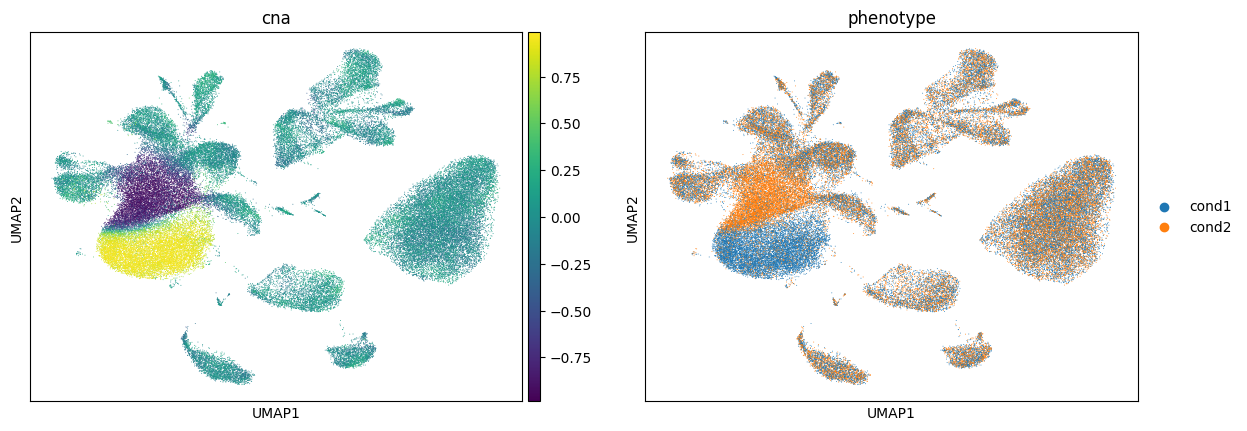

In [11]:
adata_larger = sc.read_h5ad(DATA_PATH + 'synth_demo_24v24_sparse.h5ad')
adata_larger.X = adata_larger.X.toarray()
PASCode.da.run_cna(
    adata_larger,
    subid_col=subid_col,
    cond_col=cond_col,
    pos_cond=pos_cond,
    neg_cond=neg_cond,
    allow_low_sample_size=True,
    use_rep='X_pca')

plt.hist(adata_larger.obs['cna'], bins=100)
sc.tl.umap(adata_larger)
sc.pl.umap(adata_larger, color=['cna', 'phenotype'])

### Run Robust Rank Aggregation (RRA)
 Users can choose to aggregate any combination of DA methods.

In [12]:
PASCode.rankaggr.rra(
    adata,
    da_methods=['milo', 'meld', 'daseq'])
print(adata.obs['aggreg_label'].value_counts())



----------------------------- RobustRankAggregation started ... -----------------------------
Aggregating positive score ranks...
Aggregating negative score ranks...
Combining positive and negative score ranks...
----------------------------- RobustRankAggregation Time cost (s): 0.39 -----------------------------


aggreg_label
 0.0    4190
 1.0     887
-1.0     865
Name: count, dtype: int64
